In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### List of model to test:
* Random Forest
* XGBoost 
* Catboost
* MLP

## I. Data processing

In [239]:
train_and_val = pd.read_excel('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/data/training.xlsx')

In [240]:
train_and_val.columns

Index(['Date', 'Vehicle Category', 'GVWR Class', 'Fuel Type', 'Model Year',
       'Fuel Technology', 'Electric Mile Range',
       'Number of Vehicles Registered at the Same Address', 'Region',
       'Vehicle Population'],
      dtype='object')

In [212]:
def summarize_df(df, max_columns=10):
    summary = {
        'shape': df.shape,
        'columns': df.columns.tolist()[:max_columns] + ['...'] if len(df.columns) > max_columns else df.columns.tolist(),
        'missing_values': {col: df.isnull().sum()[col] for col in df.columns[:max_columns]} if len(df.columns) > max_columns else df.isnull().sum().to_dict(),
        'describe': df.describe(include='all').iloc[:, :max_columns].to_dict() if len(df.columns) > max_columns else df.describe(include='all').to_dict(),
        'num_columns': len(df.columns),
        'distinct_values': {col: df[col].nunique() for col in df.columns[:max_columns]} if len(df.columns) > max_columns else {col: df[col].nunique() for col in df.columns},
        'columns_with_few_distinct_values': {col: df[col].unique().tolist() for col in df.columns[:max_columns] if df[col].nunique() < 20} if len(df.columns) > max_columns else {col: df[col].unique().tolist() for col in df.columns if df[col].nunique() < 20}
    }
    return summary


In [241]:
import json
summary = summarize_df(train_and_val)

with open('summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

In [242]:
# Data processing

# Convert 'Date' to datetime format and extract the year
train_and_val['Date'] = pd.to_datetime(train_and_val['Date'], format='%Y').dt.year

# Fill missing values in 'Model Year' with the median value
train_and_val['Model Year'].fillna(train_and_val['Model Year'].median(), inplace=True)

# Convert 'Model Year' to integer
train_and_val['Model Year'] = train_and_val['Model Year'].astype(int)

# Convert categorical columns to category dtype
categorical_columns = ['Vehicle Category', 'GVWR Class', 'Fuel Type', 'Fuel Technology', 'Electric Mile Range', 'Number of Vehicles Registered at the Same Address', 'Model Year']
for col in categorical_columns:
    train_and_val[col] = train_and_val[col].astype('category')

# Remove duplicates
train_and_val.drop_duplicates(inplace=True)

# Reset index
train_and_val.reset_index(drop=True, inplace=True)

# Display the cleaned dataframe
train_and_val = train_and_val.drop(columns=["Region"])

In [243]:
# Load data (replace with your actual dataset)
data = train_and_val
# Preprocessing
# One-hot encode categorical columns
categorical_cols = ["Vehicle Category", "Fuel Type", "Fuel Technology", "Electric Mile Range"]
data = pd.get_dummies(data, columns=categorical_cols)

In [244]:
# Ordinal encode "Number of Vehicles Registered at the Same Address"
ordinal_mapping = {1: int(1), 2: int(2), 3: int(3), "\u22654": 4, "Unknown": -1}
data["Number of Vehicles Registered at the Same Address"] = data["Number of Vehicles Registered at the Same Address"].map(ordinal_mapping)

In [245]:
# Preprocessing
# Impute missing values in "Model Year"
imputer = SimpleImputer(strategy="median")
data["Model Year"] = imputer.fit_transform(data[["Model Year"]])
# Handle non-numeric values in "GVWR Class"
# For this GVWR, we find that online but decided to not replace it with any value since we still treat it as categorical
data["GVWR Class"] = data["GVWR Class"].replace({"Not Applicable": -1, "Unknown": -1})

In [246]:
# Feature engineering
data["Vehicle Age"] = data["Date"] - data["Model Year"]

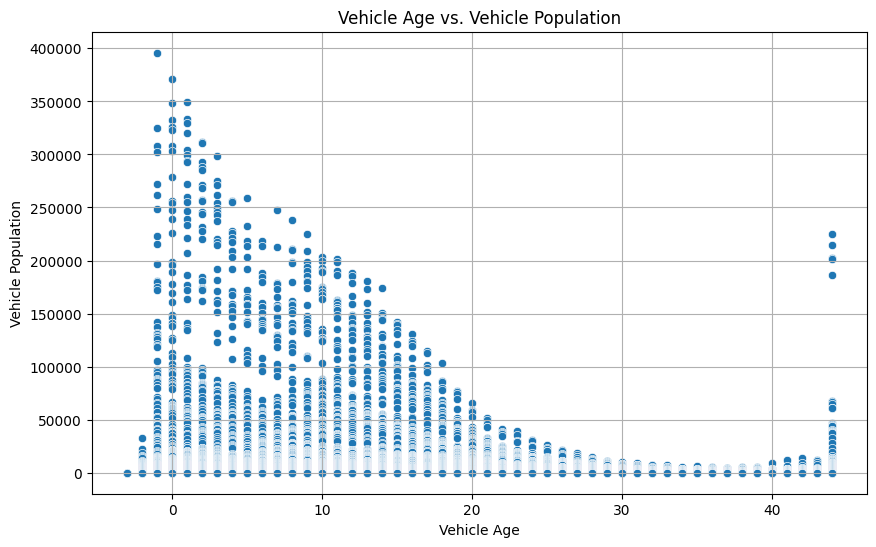

In [247]:
# Plot the new feature "Vehicle Age" and "Vehicle Population"
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Vehicle Age", y="Vehicle Population", data=data)
plt.title("Vehicle Age vs. Vehicle Population")
plt.xlabel("Vehicle Age")
plt.ylabel("Vehicle Population")
plt.grid(True)
plt.show()

In [248]:
# Check for missing values in the dataset
print("Missing values in each column:")
print(data.isnull().sum())

# Handle missing values in all columns
for col in data.columns:
    if data[col].dtype == "object" or pd.api.types.is_categorical_dtype(data[col]):  # Categorical columns
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:  # Numerical columns
        data[col].fillna(data[col].median(), inplace=True)

Missing values in each column:
Date                                                 0
GVWR Class                                           0
Model Year                                           0
Number of Vehicles Registered at the Same Address    0
Vehicle Population                                   0
Vehicle Category_B                                   0
Vehicle Category_BS                                  0
Vehicle Category_BT                                  0
Vehicle Category_MC                                  0
Vehicle Category_MH                                  0
Vehicle Category_P                                   0
Vehicle Category_T1                                  0
Vehicle Category_T2                                  0
Vehicle Category_T3                                  0
Vehicle Category_T4                                  0
Vehicle Category_T5                                  0
Vehicle Category_T6                                  0
Vehicle Category_T7               

In [249]:
# Split data
X = data.drop(columns=["Vehicle Population"])
y = data["Vehicle Population"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### III. Testset
#### 3. Build test set

In [250]:
df_test = pd.read_excel('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/data/scoring & submission format.xlsx')
test_data = df_test

# Convert 'Date' to datetime format and extract the year
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%Y').dt.year
# Fill missing values in 'Model Year' with the median value
test_data['Model Year'].fillna(test_data['Model Year'].median(), inplace=True)
# Convert 'Model Year' to integer
test_data['Model Year'] = test_data['Model Year'].astype(int)

# Convert categorical columns to category dtype
categorical_columns = ['Vehicle Category', 'GVWR Class', 'Fuel Type', 'Fuel Technology', 'Electric Mile Range', 'Number of Vehicles Registered at the Same Address', 'Region']
for col in categorical_columns:
    test_data[col] = test_data[col].astype('category')
# One-hot encode categorical columns
categorical_cols = ["Vehicle Category", "Fuel Type", "Fuel Technology", "Electric Mile Range"]
test_data = pd.get_dummies(df_test, columns=categorical_cols)
# Display the cleaned dataframe
test_data = test_data.drop(columns=["Region"])
# Remove duplicates
test_data.drop_duplicates(inplace=True)
# Reset index
test_data.reset_index(drop=True, inplace=True)
test_data
# Ordinal encode "Number of Vehicles Registered at the Same Address"
ordinal_mapping = {1: int(1), 2: int(2), 3: int(3), "\u22654": 4, "Unknown": -1}
test_data["Number of Vehicles Registered at the Same Address"] = test_data["Number of Vehicles Registered at the Same Address"].map(ordinal_mapping)

# Preprocessing
# Impute missing values in "Model Year"
imputer = SimpleImputer(strategy="median")
test_data["Model Year"] = imputer.fit_transform(test_data[["Model Year"]])
# Handle non-numeric values in "GVWR Class"
test_data["GVWR Class"] = test_data["GVWR Class"].replace({"Not Applicable": -1, "Unknown": -1})

# # Feature engineering
test_data["Vehicle Age"] = test_data["Date"] - test_data["Model Year"]

# Check for missing values in the test_dataset
print("Missing values in each column:")
print(test_data.isnull().sum())
# Handle missing values in all columns
for col in test_data.columns:
    if test_data[col].dtype == "object" or pd.api.types.is_categorical_dtype(test_data[col]):  # Categorical columns
        test_data[col].fillna(test_data[col].mode()[0], inplace=True)
    else:  # Numerical columns
        test_data[col].fillna(test_data[col].median(), inplace=True)

# Split test_data
X_test = test_data.drop(columns=["Vehicle Population"])
y_test = test_data["Vehicle Population"]

"""
Handle missing columns of X_test, which is Fuel Type_Unknown
"""

# Find the index of 'Fuel Type_Natural Gas'
insert_index = X_test.columns.get_loc('Fuel Type_Natural Gas') + 1

# Insert 'Fuel Type_Unknown' after 'Fuel Type_Natural Gas' and fill with 0
X_test.insert(insert_index, 'Fuel Type_Unknown', 0)

# Now X_test has the 'Fuel Type_Unknown' column after 'Fuel Type_Natural Gas'
print(X_test.columns)
X_test

Missing values in each column:
Date                                                 0
GVWR Class                                           0
Model Year                                           0
Number of Vehicles Registered at the Same Address    0
Vehicle Population                                   0
Vehicle Category_B                                   0
Vehicle Category_BS                                  0
Vehicle Category_BT                                  0
Vehicle Category_MC                                  0
Vehicle Category_MH                                  0
Vehicle Category_P                                   0
Vehicle Category_T1                                  0
Vehicle Category_T2                                  0
Vehicle Category_T3                                  0
Vehicle Category_T4                                  0
Vehicle Category_T5                                  0
Vehicle Category_T6                                  0
Vehicle Category_T7               

,Date,GVWR Class,Model Year,Number of Vehicles Registered at the Same Address,Vehicle Category_B,Vehicle Category_BS,Vehicle Category_BT,Vehicle Category_MC,Vehicle Category_MH,Vehicle Category_P,...,Fuel Technology_FCEV,Fuel Technology_ICE,Fuel Technology_PHEV,Electric Mile Range_0 to 50 miles,Electric Mile Range_101 to 150 miles,Electric Mile Range_51 to 100 miles,Electric Mile Range_>150 miles,Electric Mile Range_Not Applicable,Electric Mile Range_Unknown,Vehicle Age
0,2024,-1,2020.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,4.0
1,2024,-1,2021.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,3.0
2,2024,-1,2022.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,2.0
3,2024,-1,2024.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0.0
4,2024,-1,2023.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7540,2024,-1,1989.0,3,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,35.0
7541,2024,-1,1988.0,2,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,36.0
7542,2024,-1,1988.0,3,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,36.0
7543,2024,-1,1987.0,2,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,37.0


## II. Random Forest

#### 2. Train Vanilla Random Forest

In [251]:
# Train Random Forest model

random_forest_model = RandomForestRegressor(random_state=28)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=28)

In [252]:
# Evaluate
import math
y_pred = random_forest_model.predict(X_val)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_val, y_pred))
print("Mean Squared Error (MSE):", math.sqrt(mean_squared_error(y_val, y_pred)))
print("R-squared (R2):", r2_score(y_val, y_pred))

# Create a DataFrame with y_val and y_pred
results_df = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
print(results_df)

Mean Absolute Error (MAE): 399.37247792803765
Mean Squared Error (MSE): 2671.9736507637435
R-squared (R2): 0.979362055053613
        y_val     y_pred
39468       1       2.19
34656       2       4.47
144    172682  154633.37
20510      39      68.35
12619     234     286.71
...       ...        ...
10406     377     345.90
29466       6      10.45
38677       1       2.12
32541       3       1.86
11153     321     330.12

[8208 rows x 2 columns]


#### 4. Parameter tuning

##### a. Using GridSearchCV

In [225]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import time

In [226]:
# Define the parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [None, 10, 20, 30],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples at a leaf node
    "max_features": ["sqrt", "log2"],  # Number of features to consider for splits
    "bootstrap": [True, False]  # Whether to use bootstrap sampling
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error",  # Use RMSE as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=3  # Disable default verbose output
)

# Track time using tqdm
start_time = time.time()
with tqdm(total=len(grid_search.param_grid) * 5, desc="Grid Search Progress") as pbar:
    # Attach the callback to GridSearchCV
    grid_search.fit(X_train, y_train)

In [ ]:
"""
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best R-squared Score: -14547067.220303629
Model 1:
Score: -14547067.220303629
RMSE on test set: 4167.32
"""

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared Score:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test R-squared:", r2_score(y_test, y_pred))

##### 2. Random state

In [181]:
# param = {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

# Initialize the Random Forest model with the specified parameters
list_rmse = []
min_rmse = 99999999
for i in tqdm(range(1, 100)):
    rf = RandomForestRegressor(random_state=i)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = rf.predict(X_test)
    rmse_now = math.sqrt(mean_squared_error(y_test, y_pred))
    if rmse_now < min_rmse:
        min_rmse = rmse_now
        print(f"GET NEW MIN RMSE: {min_rmse} at state {i}")
    list_rmse.append({"state": i, "rmse": rmse_now})
    
top_5_rmse = sorted(list_rmse, key=lambda x: x['rmse'])[:5]
for top_rmse in top_5_rmse:
    print("State:", top_rmse['state'])
    print("Mean Squared Error (MSE):", top_rmse['rmse'])

    # # Create a DataFrame with y_test and y_pred
    # results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    # print(results_df)

  1%|          | 1/99 [00:18<30:45, 18.83s/it]

GET NEW MIN RMSE: 3819.0698253265646 at state 1


  2%|▏         | 2/99 [00:32<25:13, 15.60s/it]

GET NEW MIN RMSE: 3797.658412485756 at state 2


  4%|▍         | 4/99 [00:56<20:51, 13.18s/it]

GET NEW MIN RMSE: 3771.4759583661867 at state 4


 12%|█▏        | 12/99 [02:56<19:37, 13.53s/it]

GET NEW MIN RMSE: 3761.9088017471486 at state 12


 28%|██▊       | 28/99 [06:13<14:55, 12.62s/it]

GET NEW MIN RMSE: 3730.855110411834 at state 28


100%|██████████| 99/99 [19:23<00:00, 11.75s/it]

State: 28
Mean Squared Error (MSE): 3730.855110411834
State: 86
Mean Squared Error (MSE): 3758.1965286714612
State: 12
Mean Squared Error (MSE): 3761.9088017471486
State: 4
Mean Squared Error (MSE): 3771.4759583661867
State: 21
Mean Squared Error (MSE): 3774.779295305305


##### Random Search (to save time)

<!-- #### b. Using Randomized GridSearch -->

In [146]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-83638092.122 total time=   1.6s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-61070439.728 total time=   1.7s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-80383072.450 total time=   1.8s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-103738001.292 total time=   2.2s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-53056551.020 total time=   2.2s
[CV 1/5] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=-46314651.

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=3)

In [147]:
# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", math.sqrt(-random_search.best_score_))

Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Best RMSE: 3815.4722499374857


In [148]:
y_pred_random = random_search.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_random))
print("Test RMSE:", rmse)

Test RMSE: 4177.8294461009555


## Test with Full data

In [253]:
X_train_full = X
y_train_full = y

In [254]:
# Train Random Forest model
param = {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
# model = RandomForestRegressor(random_state=42, **param)
model = RandomForestRegressor(random_state=28)
# model.fit(X_train_full, y_train_full)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=28)

In [255]:
from sklearn.utils import shuffle
import math 
# Shuffle X_test and y_test
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Evaluate
y_pred_val = model.predict(X_val)
print("VALIDATION SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_val, y_pred_val))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_val, y_pred_val)))
print("R-squared (R2):", r2_score(y_val, y_pred_val))

print("*" * 50)
y_pred = model.predict(X_test)
print("TEST SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared (R2):", r2_score(y_test, y_pred))

# Create a DataFrame with y_val and y_pred
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
print(results_df)

VALIDATION SET
Mean Absolute Error (MAE): 399.37247792803765
Root Mean Squared Error (RMSE): 2671.9736507637435
R-squared (R2): 0.979362055053613
**************************************************
TEST SET
Mean Absolute Error (MAE): 559.9337668702073
Root Mean Squared Error (RMSE): 3730.855110411834
R-squared (R2): 0.9632727068580254
      y_test     y_pred
3612      47      44.26
393    11999   11079.94
6996       1      41.90
5216       7       4.47
23    183742  180328.07
...      ...        ...
5191       7      57.31
5226       7       5.76
5390       6      10.85
860     2551    3888.65
7270       1       1.07

[7545 rows x 2 columns]


## IV. New models

### 1. CatBoost only

In [256]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the parameter grid
param_grid = {
    "iterations": [500, 1000, 1500],  # Number of trees
    "learning_rate": [0.01, 0.05, 0.1],  # Step size shrinkage
    "depth": [4, 6, 8],  # Depth of the trees
    "l2_leaf_reg": [1, 3, 5],  # L2 regularization
    "random_strength": [0.1, 0.5, 1],  # Randomness for scoring splits
    "bagging_temperature": [0, 0.5, 1],  # Controls Bayesian bagging
    "border_count": [32, 64, 128],  # Number of splits for numerical features
    "verbose": [False]  # Disable verbose output during grid search
}

In [257]:
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
# Define categorical columns
categorical_cols = list(X_train_cat.columns)
# Convert all columns to string
X_train_cat[categorical_cols] = X_train_cat[categorical_cols].astype(str)
X_test_cat[categorical_cols] = X_test_cat[categorical_cols].astype(str)
X_train_cat[categorical_cols] = X_train_cat[categorical_cols].astype(str)


In [122]:
# Create the CatBoost model
catboost_model = CatBoostRegressor(random_state=28)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings to sample
    scoring="neg_root_mean_squared_error",  # Use RMSE as the scoring metric
    cv=5,  # 5-fold cross-validation
    verbose=3,  # Print progress
    random_state=28,
    n_jobs=-1  # Use all available cores
)

# Fit the model
random_search.fit(X_train_cat, y_train, cat_features=categorical_cols)

# Best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5] END bagging_temperature=1, border_count=32, depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.01, random_strength=1, verbose=False;, score=-5925.668 total time=  15.2s
[CV 1/5] END bagging_temperature=1, border_count=32, depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.01, random_strength=1, verbose=False;, score=-6863.605 total time=  15.5s
[CV 3/5] END bagging_temperature=1, border_count=32, depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.01, random_strength=1, verbose=False;, score=-6328.931 total time=  15.4s
[CV 4/5] END bagging_temperature=1, border_count=32, depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.01, random_strength=1, verbose=False;, score=-6463.974 total time=  12.1s
[CV 1/5] END bagging_temperature=0.5, border_count=128, depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, random_strength=0.1, verbose=False;, score=-6657.260 total time=  28.0s
[CV 5/5] END bagg

In [258]:
best_params_catboost = {'verbose': False, 'random_strength': 0.5, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8, 'border_count': 32, 'bagging_temperature': 1}
# best_params_catboost = {"bagging_temperature":0.5, "border_count":32, "depth":8, "iterations":1000, "l2_leaf_reg":3, "learning_rate":0.1, "random_strength":0.1, "verbose":False}
# Train the model with the best parameters
best_catboost_model = CatBoostRegressor(
    **best_params_catboost,
    random_state = 42
    # verbose=3  # Enable verbose output for training
)

best_catboost_model.fit(X_train_cat, y_train, cat_features=categorical_cols)

# Predictions
catboost_preds = best_catboost_model.predict(X_test_cat)

# Evaluate
from sklearn.metrics import mean_squared_error
catboost_rmse = np.sqrt(mean_squared_error(y_test, catboost_preds))
print(f"CatBoost RMSE: {catboost_rmse}")

CatBoost RMSE: 5631.50060037337


In [259]:
import math 
from sklearn.utils import shuffle
# Shuffle X_test and y_test
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print("*" * 50)
y_test_pred_catboost = best_catboost_model.predict(X_test_cat)
print("TEST SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred_catboost))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_catboost)))
print("R-squared (R2):", r2_score(y_test, y_test_pred_catboost))

# Create a DataFrame with y_val and y_test_pred_catboost
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_test_pred_catboost})
print(results_df)

**************************************************
TEST SET
Mean Absolute Error (MAE): 7241.8570332624895
Root Mean Squared Error (RMSE): 26293.284452997123
R-squared (R2): -0.8241554051083977
      y_test         y_pred
7237       1     311.052884
3434      58    6164.186458
740     3425     343.965411
2875     112    -160.550842
554     5771  173388.356971
...      ...            ...
6061       3    -514.828711
7177       1     922.667802
1394     853    -321.436466
1726     495    1895.781174
202    39131    -120.803823

[7545 rows x 2 columns]


### 2. LightGBM

In [137]:
# Convert categorical columns to 'category' dtype
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
categorical_cols = X_train_lgb.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

# Get the indices of categorical columns
categorical_indices = [X_train_lgb.columns.get_loc(col) for col in categorical_cols]

# Create LightGBM datasets with categorical features
lgb_train = lgb.Dataset(X_train_lgb, label=y_train, categorical_feature=categorical_indices)
lgb_test = lgb.Dataset(X_test_lgb, label=y_test, categorical_feature=categorical_indices, reference=lgb_train)

In [130]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the parameter grid
param_grid = {
    "objective": ["regression"],
    "metric": ["rmse"],
    "boosting_type": ["gbdt", "dart"],
    "num_leaves": [31, 50, 100],
    "learning_rate": [0.01, 0.05, 0.1],
    "feature_fraction": [0.8, 0.9, 1.0],
    "bagging_fraction": [0.8, 0.9, 1.0],
    "bagging_freq": [0, 5, 10],
    "min_data_in_leaf": [20, 50, 100],
    "lambda_l1": [0, 0.1, 0.5],
    "lambda_l2": [0, 0.1, 0.5],
    "random_state": [28],
    "shrinkage_rate": [0.01, 0.012, 0.015]
}

# Create the LightGBM regressor
lgb_model = LGBMRegressor()

# RandomizedSearchCV
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring='neg_root_mean_squared_error',  # Use RMSE as the scoring metric
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=28,
    n_jobs=-1  # Use all available cores
)

# Fit the model
random_search_lgb.fit(X_train, y_train)

# Best parameters
best_params_lgb = random_search_lgb.best_params_
print("Best Parameters:", best_params_lgb)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] learning_rate is set=0.05, shrinkage_rate=0.01 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] lambda_l2 is

In [135]:
best_params_lgb

{'shrinkage_rate': 0.01,
 'random_state': 28,
 'objective': 'regression',
 'num_leaves': 100,
 'min_data_in_leaf': 20,
 'metric': 'rmse',
 'learning_rate': 0.1,
 'lambda_l2': 0,
 'lambda_l1': 0,
 'feature_fraction': 0.8,
 'boosting_type': 'gbdt',
 'bagging_freq': 0,
 'bagging_fraction': 0.8}

In [138]:
# Train the model with the best parameters
lgb_model_best = LGBMRegressor(**best_params_lgb)
lgb_model_best.fit(X_train_lgb, y_train)

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] learning_rate is set=0.1, shrinkage_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lamb

LGBMRegressor(bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.8,
              lambda_l1=0, lambda_l2=0, metric='rmse', min_data_in_leaf=20,
              num_leaves=100, objective='regression', random_state=28,
              shrinkage_rate=0.01)

In [139]:
import math 
from sklearn.utils import shuffle
# Shuffle X_test and y_test
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print("*" * 50)
y_test_pred_lgb = lgb_model_best.predict(X_test)
print("TEST SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred_lgb))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_lgb)))
print("R-squared (R2):", r2_score(y_test, y_test_pred_lgb))

# Create a DataFrame with y_val and y_test_pred_lgb
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_test_pred_lgb})
print(results_df)

**************************************************
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] learning_rate is set=0.1, shrinkage_rate=0.01 will be ignored. Current value: learning_rate=0.1
TEST SET
Mean Absolute Error (MAE): 12803.182732725518
Root Mean Squared Error (RMSE): 24216.38850495135
R-squared (R2): -0.5473583595655669
      y_test        y

### 3. Stacking RF + CatBoost

#### a. Use LR as a correlation mechanism

In [187]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Train all models (assuming you already have trained models)
rf_preds = random_forest_model.predict(X_test)
cb_preds = best_catboost_model.predict(X_test_cat)

# Step 2: Create a new dataset using model predictions as features
stacked_features = np.column_stack((rf_preds, cb_preds))

# Step 3: Train the meta-model (using RF predictions as the main guidance)
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_test)

# Step 4: Predict using the meta-model
stacked_preds = meta_model.predict(stacked_features)

# Step 5: Ensure non-negative predictions (since vehicle population can't be negative)
stacked_preds = np.maximum(stacked_preds, 0)

# Step 6: Evaluate performance
print("*" * 50)
rmse_stacked = np.sqrt(mean_squared_error(y_test, stacked_preds))
print("TEST SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, stacked_preds))
print("Root Mean Squared Error (RMSE):", rmse_stacked)
print("R-squared (R2):", r2_score(y_test, stacked_preds))

# Create a DataFrame with y_val and stacked_preds
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': stacked_preds})
print(results_df)


**************************************************
TEST SET
Mean Absolute Error (MAE): 586.2693242193302
Root Mean Squared Error (RMSE): 3553.541137458693
R-squared (R2): 0.9666807782012975
      y_test         y_pred
0     316065  274837.728307
1     315986  278185.301704
2     306487  275567.567929
3     284754  250934.882613
4     284153  264269.665175
...      ...            ...
7540       1       0.000000
7541       1       0.000000
7542       1       0.000000
7543       1       0.000000
7544       1       0.000000

[7545 rows x 2 columns]


### 2. Assign weights

**************************************************
TEST SET (Weighted Averaging)
Mean Absolute Error (MAE): 956.5360532642312
Root Mean Squared Error (RMSE): 4075.4506364333542
R-squared (R2): 0.9561748482070743
      y_test         y_pred
0     316065  261510.096887
1     315986  265513.712911
2     306487  262559.599814
3     284754  238974.613287
4     284153  269180.570598
...      ...            ...
7540       1       0.000000
7541       1       0.000000
7542       1      46.557616
7543       1     172.557159
7544       1      37.458081

[7545 rows x 2 columns]


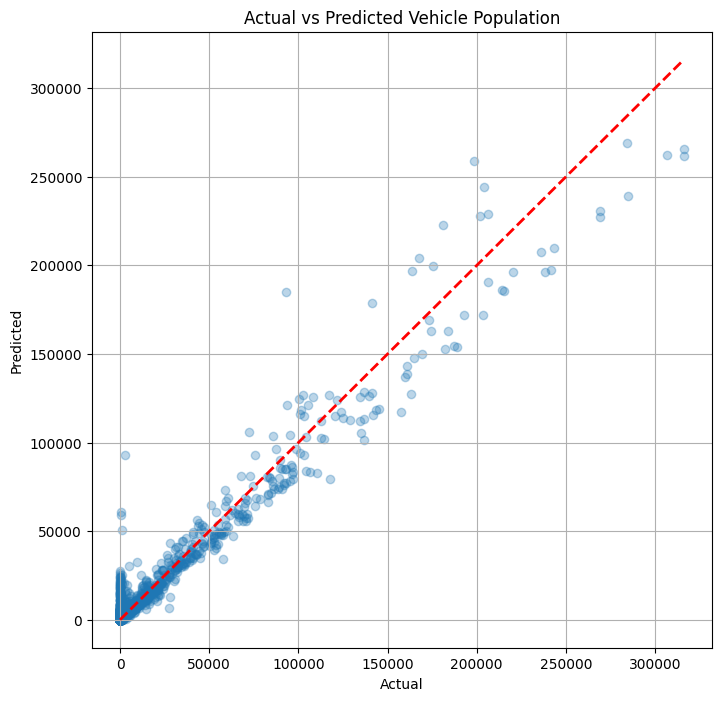

In [201]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Generate predictions from base models
rf_preds = random_forest_model.predict(X_test)
cb_preds = best_catboost_model.predict(X_test_cat)

# Step 2: Apply weighted averaging
rf_weight = 0.9 # Give more importance to Random Forest
cb_weight = 0.1  # Less weight to CatBoost

stacked_preds = (rf_weight * rf_preds) + (cb_weight * cb_preds)

# Step 3: Ensure non-negative predictions
stacked_preds = np.maximum(stacked_preds, 0)

# Step 4: Evaluate performance
rmse_stacked = np.sqrt(mean_squared_error(y_test, stacked_preds))
mae_stacked = mean_absolute_error(y_test, stacked_preds)
r2_stacked = r2_score(y_test, stacked_preds)

# Print evaluation metrics
print("*" * 50)
print("TEST SET (Weighted Averaging)")
print(f"Mean Absolute Error (MAE): {mae_stacked}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacked}")
print(f"R-squared (R2): {r2_stacked}")

# Step 5: Show predictions
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': stacked_preds})
print(results_df)
# Plot the actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, stacked_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Vehicle Population')
plt.grid(True)
plt.show()


#### 3. 2 RF + 1 Catboost -> LR

In [179]:
# Train second Random Forest model with more trees
rf_params = {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
random_forest_model_2 = RandomForestRegressor(random_state=28, **rf_params)
random_forest_model_2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=5,
                      n_estimators=500, random_state=28)

**************************************************
TEST SET (Weighted Averaging with Two RF Models)
Mean Absolute Error (MAE): 590.4733933624395
Root Mean Squared Error (RMSE): 3550.8614712476633
R-squared (R2): 0.9667310101954927
      y_test         y_pred
0     316065  273738.025784
1     315986  277989.388057
2     306487  275410.867368
3     284754  250502.617032
4     284153  264133.017351
...      ...            ...
7540       1       0.000000
7541       1       0.000000
7542       1       0.000000
7543       1       0.000000
7544       1       0.000000

[7545 rows x 2 columns]


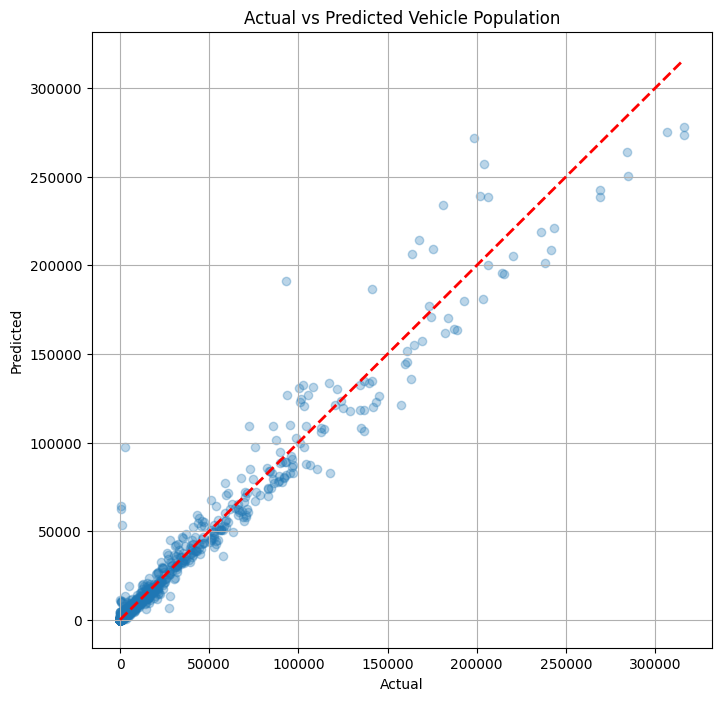

In [200]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Generate predictions from base models
rf_preds_1 = random_forest_model.predict(X_test)  # First Random Forest model
rf_preds_2 = random_forest_model_2.predict(X_test)  # Second Random Forest model (with different hyperparameters)
cb_preds = best_catboost_model.predict(X_test_cat)  # CatBoost predictions

# Step 2: Apply weighted averaging
rf_weight = 0.75  # Give more importance to Random Forest
rf_2_weight = 0.25  # Slightly lower weight to the second Random Forest
cb_weight = 0.00  # Less weight to CatBoost

# # Combining predictions using weighted averaging
# stacked_preds = (rf_weight * rf_preds_1) + (rf_2_weight * rf_preds_2) + (cb_weight * cb_preds)

# # Step 3: Ensure non-negative predictions (as vehicle population can't be negative)
# stacked_preds = np.maximum(stacked_preds, 0)
# Step 2: Create a new dataset using model predictions as features
stacked_features = np.column_stack((rf_preds_1, rf_preds_2, cb_preds))

# Step 3: Train the meta-model (using RF predictions as the main guidance)
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_test)

# Step 4: Predict using the meta-model
stacked_preds = meta_model.predict(stacked_features)

# Step 5: Ensure non-negative predictions (since vehicle population can't be negative)
stacked_preds = np.maximum(stacked_preds, 0)
# Step 4: Evaluate performance
rmse_stacked = np.sqrt(mean_squared_error(y_test, stacked_preds))
mae_stacked = mean_absolute_error(y_test, stacked_preds)
r2_stacked = r2_score(y_test, stacked_preds)

# Print evaluation metrics
print("*" * 50)
print("TEST SET (Weighted Averaging with Two RF Models)")
print(f"Mean Absolute Error (MAE): {mae_stacked}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacked}")
print(f"R-squared (R2): {r2_stacked}")

# Step 5: Show predictions
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': stacked_preds})
print(results_df)
# Plot the actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, stacked_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Vehicle Population')
plt.grid(True)
plt.show()
results_df.to_csv('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/output/results.csv', index=False)

#### 4. Stack 2rf + 1cat -> rf

Root Mean Squared Error (RMSE): 1550.3245712610415
**************************************************
TEST SET (Weighted Averaging with Two RF Models)
Mean Absolute Error (MAE): 238.01334791252484
Root Mean Squared Error (RMSE): 1550.3245712610415
R-squared (R2): 0.9561748482070743
      y_test     y_pred
0     316065  295832.43
1     315986  295580.63
2     306487  293086.08
3     284754  258394.25
4     284153  261972.52
...      ...        ...
7540       1       1.10
7541       1       3.00
7542       1       1.68
7543       1       1.71
7544       1       1.77

[7545 rows x 2 columns]


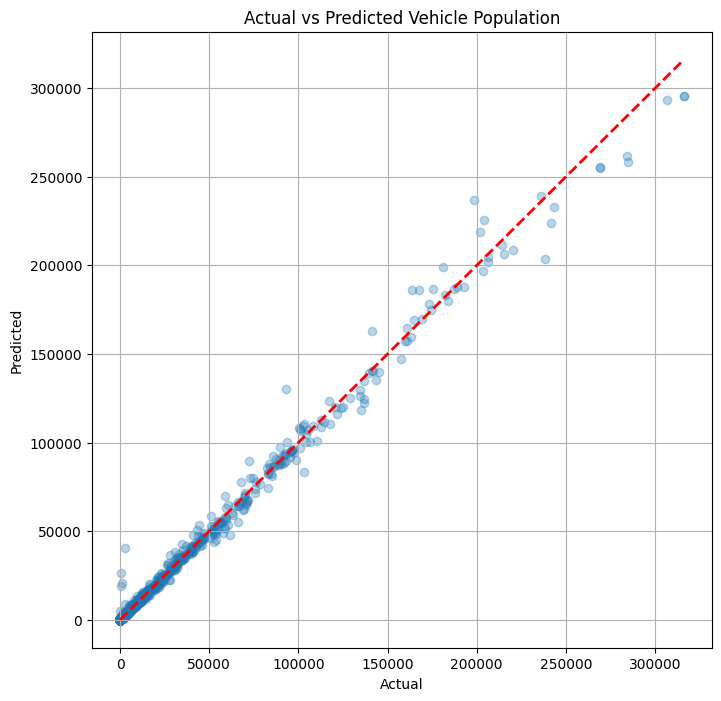

In [204]:
# Assuming CatBoost is already trained
# Step 2: Generate predictions on the test set
rf_preds_1 = random_forest_model.predict(X_test)  # First Random Forest model
rf_preds_2 = random_forest_model_2.predict(X_test)  # Second Random Forest model (with different hyperparameters)
cb_preds = best_catboost_model.predict(X_test_cat)  # CatBoost predictions

# Step 3: Stack the predictions from the base models

"""
First, I try with 2 RF only. The result is good, with ~1788 RMSE. Then, I try with 3 models: 2 RF and 1 CatBoost. The result is better.
* Reason: The CatBoost model provides additional information that can help improve the predictions and can detect extreme case (the vehicle population is very small, which is <10).
"""
# stacked_features = np.column_stack((rf_preds_1, rf_preds_2)) 
stacked_features = np.column_stack((rf_preds_1, rf_preds_2, cb_preds))

# Step 4: Train the meta-model (Random Forest)
meta_rf = RandomForestRegressor(random_state=28)
meta_rf.fit(stacked_features, y_test)

# Step 5: Make final predictions
stacked_preds = meta_rf.predict(stacked_features)

# Step 6: Evaluate performance
mae_stacked = mean_absolute_error(y_test, stacked_preds)
rmse_stacked = np.sqrt(mean_squared_error(y_test, stacked_preds))
print("Root Mean Squared Error (RMSE):", rmse_stacked)
# Print evaluation metrics
print("*" * 50)
print("TEST SET (Weighted Averaging with Two RF Models)")
print(f"Mean Absolute Error (MAE): {mae_stacked}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacked}")
print(f"R-squared (R2): {r2_stacked}")

# Step 5: Show predictions
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': stacked_preds})
print(results_df)
# Plot the actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, stacked_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Vehicle Population')
plt.grid(True)
plt.show()
results_df.to_csv('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/output/results.csv', index=False)

**LET FUCKING GO!!!!!!!**

#### 4. Log trans